### Cross-Validation with Linear Regression
This notebook demonstrates how to do cross-validation (CV) with linear regression as an example (it is heavily used in almost all modelling techniques such as decision trees, SVM etc.). We will mainly use sklearn to do cross-validation.

This notebook is divided into the following parts: 0. Experiments to understand overfitting

- Building a linear regression model without cross-validation
- Problems in the current approach
- Cross-validation: A quick recap
- Cross-validation in sklearn:
     - K-fold CV
     - Hyperparameter tuning using CV
     - Other CV schemes

### 0. Experiments to Understand Overfitting

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

In [2]:
data = pd.read_csv('Housing.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
data.shape

(545, 13)

The above housing data has only 545 data points which is very limited, so we will apply cross validation technique for our model evaluation.

But for first experiment we will do a linear regression with 1 variable. Let's take `price` and `area`.

In [4]:
df = data[['price', 'area']]
df.head()

,price,area
0,13300000,7420
1,12250000,8960
2,12250000,9960
3,12215000,7500
4,11410000,7420


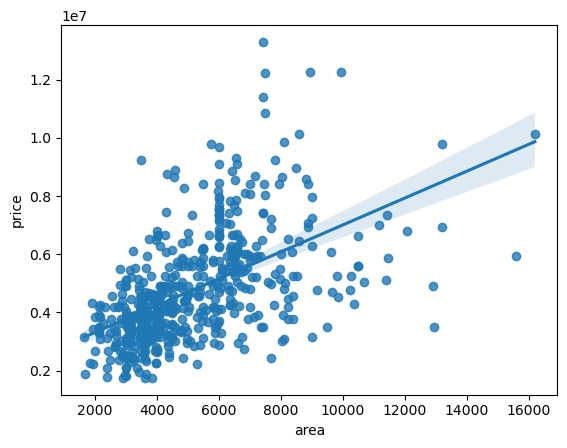

In [5]:
sns.regplot(data = df, x = 'area', y = 'price')
plt.show()

In [6]:
# split data into train and test

df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=10)

In [7]:
df_train.shape, df_test.shape

((381, 2), (164, 2))

In [8]:
cols = df_train.columns
scaler = MinMaxScaler()
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train), columns=cols)
df_test = pd.DataFrame(scaler.transform(df_test), columns=cols)

In [9]:
df_train.describe()

,price,area
count,381.000000,381.000000
mean,0.264227,0.242041
std,0.167572,0.147100
min,0.000000,0.000000
25%,0.142424,0.136691
50%,0.227273,0.201439
75%,0.357576,0.326619
max,1.000000,1.000000


In [10]:
df_test.describe()

,price,area
count,164.000000,164.000000
mean,0.254130,0.262642
std,0.148291,0.174945
min,0.000000,-0.003597
25%,0.156061,0.135252
50%,0.220000,0.223561
75%,0.321970,0.352518
max,0.909091,1.043165


In [11]:
X_train = df_train['area']
X_test = df_test['area']
y_train = df_train['price']
y_test = df_test['price']

In [12]:
# convert series to np array for X_train and X_test

X_train = np.reshape(X_train, (-1, 1))
X_test = np.reshape(X_test, (-1, 1))

In [13]:
X_train.shape

(381, 1)

### Polynomial regression

With polynomial regression we will see the overfitting issue in complex model. We will define degrees and then visualize and identify the performance of the model in training and testing set. To do this we will use polynomial regression.

**Note:** Ploynomial regression with 1 degree is linear regression.

In [14]:
degrees = [1, 2, 3, 6, 10, 20]

y_train_pred_df = np.zeros((len(X_train), len(degrees)))
y_test_pred_df = np.zeros((len(X_test), len(degrees)))

for i in range(0, len(degrees)):
    deg = degrees[i]
    pipeline = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    train_acc = round(r2_score(y_train, y_train_pred), 3)
    test_acc = round(r2_score(y_test, y_test_pred), 3)
    print('Accuracy of model with degree {0} on train set = {1} and test set = {2}'.format(deg, train_acc, test_acc))
    y_train_pred_df[:, i] = y_train_pred
    y_test_pred_df[:, i] = y_test_pred

Accuracy of model with degree 1 on train set = 0.293 and test set = 0.248
Accuracy of model with degree 2 on train set = 0.344 and test set = 0.225
Accuracy of model with degree 3 on train set = 0.344 and test set = 0.223
Accuracy of model with degree 6 on train set = 0.365 and test set = 0.115
Accuracy of model with degree 10 on train set = 0.372 and test set = -108.764
Accuracy of model with degree 20 on train set = 0.38 and test set = -328934257047.727


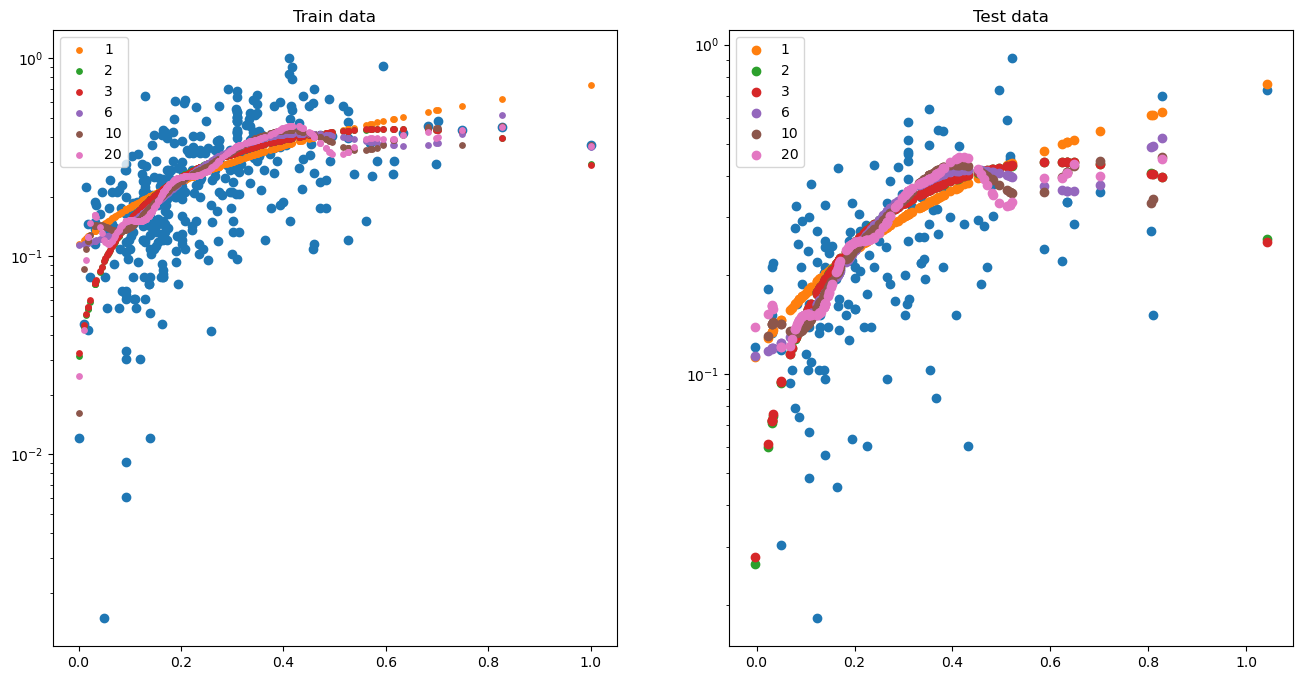

In [15]:
plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred_df[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred_df[:, i], label=str(degree))
    plt.legend(loc='upper left')

In above plot we can see that the model with degree = 20 is trying to overfit on train data. As you can observe, the training score is increasing while the test score is decreasing as the degree of the polynomial is increasing. This is a clear sign of overfitting.

### 1. Building a linear regression model without cross-validation

In [16]:
# map binary variables into 0-1

binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data[binary_vars] = data[binary_vars].apply(lambda x: x.map({'yes': 1, 'no': 0}))
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [17]:
# create dummy variables for categorical variables

data = pd.get_dummies(data, columns=['furnishingstatus'], drop_first=True, dtype='int32')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [18]:
# split data into train and test

train_data, test_data = train_test_split(data, train_size=0.7, test_size=0.3, random_state=100)

In [19]:
train_data.shape

(381, 14)

In [20]:
test_data.shape

(164, 14)

In [21]:
# rescale numeric variables in train and test data
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
scaler = MinMaxScaler()
scaler.fit(train_data[numeric_vars])
train_data[numeric_vars] = scaler.transform(train_data[numeric_vars])
test_data[numeric_vars] = scaler.transform(test_data[numeric_vars])

In [22]:
train_data.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.260333,0.288710,0.386352,0.136483,0.268591,0.855643,0.170604,0.351706,0.052493,0.299213,0.242345,0.233596,0.414698,0.325459
std,0.157607,0.181420,0.147336,0.237325,0.295001,0.351913,0.376657,0.478131,0.223313,0.458515,0.285933,0.423674,0.493318,0.469162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.151515,0.155227,0.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.221212,0.234424,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.345455,0.398099,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
test_data.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.263176,0.298548,0.408537,0.158537,0.268293,0.865854,0.195122,0.347561,0.030488,0.353659,0.205285,0.237805,0.420732,0.329268
std,0.172077,0.211922,0.147537,0.281081,0.276007,0.341853,0.397508,0.477654,0.172452,0.479569,0.289322,0.427043,0.495189,0.471387
min,0.006061,-0.016367,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142424,0.148011,0.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.226061,0.259724,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.346970,0.397439,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,0.909091,1.263992,0.800000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# create X_train, y_train, X_test and y_test

y_train = train_data['price']
X_train = train_data.drop(columns=['price'], axis=1)

y_test = test_data['price']
X_test = test_data.drop(columns=['price'], axis=1)

In [25]:
X_train.shape

(381, 13)

#### Using RFE 

Now, we have 13 predictor features. To build the model using RFE, we need to tell RFE how many features we want in the final model. It then runs a feature elimination algorithm. 

Note that the number of features to be used in the model is a **hyperparameter**.

In [26]:
lr = LinearRegression()
rfe = RFE(LinearRegression(), n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [27]:
for i in range(0, len(X_train.columns)):
    print('{}, {}, {}'.format(X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))

area, True, 1
bedrooms, True, 1
bathrooms, True, 1
stories, True, 1
mainroad, True, 1
guestroom, True, 1
basement, False, 3
hotwaterheating, True, 1
airconditioning, True, 1
parking, True, 1
prefarea, True, 1
furnishingstatus_semi-furnished, False, 4
furnishingstatus_unfurnished, False, 2


In [28]:
X_train = X_train.drop(columns=['furnishingstatus_unfurnished', 'basement', 'furnishingstatus_semi-furnished'], axis=1)

In [29]:
X_train.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,hotwaterheating,airconditioning,parking,prefarea
359,0.155227,0.4,0.0,0.000000,1,0,0,0,0.333333,0
19,0.403379,0.4,0.5,0.333333,1,0,0,1,0.333333,1
159,0.115628,0.4,0.5,0.000000,1,1,0,1,0.000000,0
35,0.454417,0.4,0.5,1.000000,1,0,0,1,0.666667,0
28,0.538015,0.8,0.5,0.333333,1,0,1,0,0.666667,0


In [30]:
X_test = X_test.drop(columns=['furnishingstatus_unfurnished', 'basement', 'furnishingstatus_semi-furnished'], axis=1)

In [31]:
X_test.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,hotwaterheating,airconditioning,parking,prefarea
265,0.091869,0.4,0.0,0.333333,1,0,0,0,0.000000,1
54,0.366420,0.4,0.5,0.333333,1,1,0,1,0.333333,0
171,0.742080,0.4,0.0,0.000000,1,0,0,0,0.333333,1
244,0.306582,0.4,0.0,0.333333,1,1,0,0,0.000000,1
268,0.274023,0.6,0.0,0.333333,1,0,0,1,0.000000,0


In [32]:
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

In [33]:
y_test_pred = lr.predict(X_test)

In [34]:
r2_score(y_test, y_test_pred)

0.6519767225566988

Let's reduce the number of feature to 6.

In [35]:
y_train = train_data['price']
X_train = train_data.drop(columns=['price'], axis=1)

y_test = test_data['price']
X_test = test_data.drop(columns=['price'], axis=1)

In [36]:
lr = LinearRegression()
rfe = RFE(LinearRegression(), n_features_to_select=6)
rfe = rfe.fit(X_train, y_train)

In [37]:
for i in range(0, len(X_train.columns)):
    print('{}, {}, {}'.format(X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))

area, True, 1
bedrooms, False, 2
bathrooms, True, 1
stories, True, 1
mainroad, False, 3
guestroom, False, 5
basement, False, 7
hotwaterheating, True, 1
airconditioning, True, 1
parking, False, 4
prefarea, True, 1
furnishingstatus_semi-furnished, False, 8
furnishingstatus_unfurnished, False, 6


In [38]:
X_train.columns[~rfe.support_]

Index(['bedrooms', 'mainroad', 'guestroom', 'basement', 'parking',
       'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished'],
      dtype='object')

In [39]:
X_train = X_train.drop(columns=X_train.columns[~rfe.support_], axis=1)
X_test = X_test.drop(columns=X_test.columns[~rfe.support_], axis=1)

In [40]:
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

In [41]:
y_test_pred = lr.predict(X_test)

In [42]:
r2_score(y_test, y_test_pred)

0.6171279856258438

The major problem in this approach is to determine the hyper parameter for the model.

## 2. Problems in the Current Approach

In train-test split, we have three options:
1. **Simply split into train and test**: But that way tuning a hyperparameter makes the model 'see' the test data (i.e. knowledge of test data leaks into the model)
2. **Split into train, validation, test sets**: Then the validation data would eat into the training set
3. **Cross-validation**: Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.

## 3. Cross-Validation: A Quick Recap

The following figure illustrates k-fold cross-validation with k=4. There are some other schemes to divide the training set, we'll look at them briefly later.

<img src="cv.png" title="K-Fold Cross Validation" />

## 4. Cross validation in sklearn

### 4.1 K-Fold CV

In [58]:
X_train = train_data.drop(columns=['price'], axis=1)
y_train = train_data['price']

In [63]:
folds = KFold(n_splits=30, shuffle=True, random_state=100)
scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_mean_squared_error', cv=folds)
np.average(scores)

-0.008634320316708435

Above k-fold approach is taking all the features of the dataset. But we have to determine the actual hyperparameter for the model.

### 4.2 Hyperparameter Tuning Using Grid Search Cross-Validation

In [45]:
# 1. define k-fold cv
folds = KFold(n_splits=5, shuffle=True, random_state=100)

# 2. define params_grid
param_grid = [{'n_features_to_select': list(range(1, 14))}]

# 3. define rfe
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

# 4. call GridSearchCV
model_cv = GridSearchCV(rfe, param_grid, cv=folds, scoring='r2', return_train_score=True)

# 5. fit train data in grid search cv
model_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2')

In [46]:
results = pd.DataFrame(model_cv.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.015197,0.003484,0.002000,0.000632,1,{'n_features_to_select': 1},0.172606,0.351721,0.206887,0.165910,...,0.243658,0.077627,13,0.302971,0.265961,0.280611,0.300768,0.269025,0.283867,0.015506
1,0.014000,0.002001,0.002000,0.000632,2,{'n_features_to_select': 2},0.335665,0.428751,0.439969,0.505321,...,0.438360,0.058374,12,0.505799,0.489802,0.462091,0.474178,0.471907,0.480755,0.015355
2,0.012602,0.002043,0.002194,0.000740,3,{'n_features_to_select': 3},0.421848,0.539257,0.491515,0.604426,...,0.516805,0.059902,11,0.568074,0.544917,0.542889,0.534685,0.542412,0.546596,0.011289
3,0.009999,0.001527,0.001801,0.000401,4,{'n_features_to_select': 4},0.449487,0.567101,0.494461,0.600237,...,0.526272,0.053074,10,0.587523,0.564018,0.549490,0.541496,0.549291,0.558364,0.016296
4,0.008194,0.000404,0.002009,0.000018,5,{'n_features_to_select': 5},0.494779,0.610200,0.492807,0.590812,...,0.541889,0.049257,8,0.620038,0.597033,0.584663,0.549413,0.589397,0.588109,0.022847
5,0.008414,0.001371,0.001804,0.000748,6,{'n_features_to_select': 6},0.512477,0.628849,0.488411,0.527379,...,0.541063,0.048029,9,0.626959,0.603122,0.596348,0.606852,0.601063,0.606869,0.010602
6,0.008806,0.001838,0.002600,0.000491,7,{'n_features_to_select': 7},0.568887,0.664093,0.552385,0.534634,...,0.577636,0.045006,7,0.658577,0.638501,0.630137,0.646285,0.638313,0.642363,0.009582
7,0.007610,0.001618,0.002381,0.000489,8,{'n_features_to_select': 8},0.570639,0.665608,0.592323,0.550001,...,0.591795,0.039428,6,0.674146,0.640825,0.654028,0.658665,0.657277,0.656988,0.010651
8,0.006801,0.000737,0.001400,0.000490,9,{'n_features_to_select': 9},0.578843,0.694189,0.606220,0.590777,...,0.615352,0.040767,4,0.676043,0.652605,0.659579,0.668996,0.664321,0.664309,0.007988
9,0.004401,0.000473,0.001999,0.000002,10,{'n_features_to_select': 10},0.574376,0.693197,0.601972,0.594335,...,0.608547,0.043498,5,0.686032,0.661729,0.674558,0.678443,0.677153,0.675583,0.007910


### 4.3 Plot graph b/w mean_train_score and mean_test_score

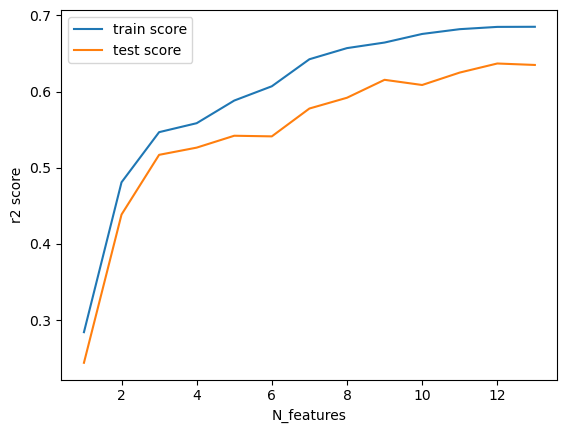

In [47]:
plt.plot(results['param_n_features_to_select'], results['mean_train_score'], label = 'train score')
plt.plot(results['param_n_features_to_select'], results['mean_test_score'], label = 'test score')
plt.legend()
plt.xlabel('N_features')
plt.ylabel('r2 score')
plt.show()

**Interpretation of above graph**

- Both train and test accuracy are almost similar when the selected features are less, because the model is too simple and hence high biased.
- The gap between train and test accuracy is increasing as the selected features are increasing and the gap is large at the end, because the model is too complex and hence the high variance.
- The optimal number of features should lie between 6 and 10.

### 4.4 Final model with optimal features

In [48]:
X_test = test_data.drop(columns=['price'], axis=1)
y_test = test_data['price']

In [49]:
n_features_to_select = 10

rfe = RFE(LinearRegression(), n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

y_test_pred = rfe.predict(X_test)
r2_score(y_test, y_test_pred)

0.6519767225566988